In [2]:
import sagemaker
import boto3

sagemaker_session = sagemaker.Session()

bucket = "amazon-sage-store"
prefix = "healthcare/heartdisease"
input_folder = "datasets"

data_key = "heart.csv"
data_location = "s3://{}/{}/{}/{}".format(bucket, prefix, input_folder, data_key)

role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::539798038106:role/service-role/AmazonSageMaker-ExecutionRole-20220710T091171


In [46]:
analysis_folder = "analysis"

analysis_reports = "s3://{}/{}/{}".format(bucket, prefix, analysis_folder)
print("Uploaded analysis report location:", analysis_reports)

Uploaded analysis report location: s3://amazon-sage-store/healthcare/heartdisease/analysis


In [57]:
import io, os

def upload_report(df, key, index=False, header=True, folder="xgboost-classifier"):

    buf = io.StringIO()
    df.to_csv(buf, index=index, header=header)

    boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, analysis_folder, folder, key)).put(Body=buf.getvalue())

    report_link = "s3://{}/{}/{}/{}/{}".format(bucket, prefix, analysis_folder, folder, key)
    print("Uploded analysis data to the location:", report_link)

In [5]:
import pandas as pd

data = pd.read_csv(data_location)
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [6]:
import numpy as np

X = np.array(data.iloc[:, :-1]).astype("float32")
y = np.array(data.iloc[:, -1]).astype("float32")

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [27]:
np.reshape(y_train, (-1, 1)).shape

(820, 1)

In [44]:
corr_matrix = pd.DataFrame(np.hstack((X_train, np.reshape(y_train, (-1, 1)))), columns=data.columns).corr()

In [53]:
upload_report(corr_matrix, "corr_matrix.csv")

Uploded analysis data to the location: s3://amazon-sage-store/healthcare/heartdisease/analysis/linear-classifier/corr_matrix.csv


In [54]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

In [56]:
print("X train:", X_train.shape)
print("y train:", y_train.shape)
print("X test:", X_test.shape)
print("y test:", y_test.shape)
print("X validation:", X_test.shape)
print("y validation:", y_test.shape)

X train: (656, 13)
y train: (656,)
X test: (205, 13)
y test: (205,)
X validation: (205, 13)
y validation: (205,)


In [8]:
buf_train = io.StringIO()
pd.DataFrame(train).to_csv(buf_train, index=False, header=False)

0

In [9]:
import os

key = "linear-classifier"
train_folder = "train"

boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, train_folder, key)).upload_fileobj(buf)

s3_train_data = "s3://{}/{}/{}/{}".format(bucket, prefix, train_folder, key)
print("Uploded training data to the location:", s3_train_data)

Uploded training data to the location: s3://amazon-sage-store/healthcare/heartdisease/train/linear-classifier


In [10]:
buf_val = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf_val, X_validation, y_validation)
buf_val.seek(0)

0

In [11]:
validation_folder = "validation"

boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, validation_folder, key)).upload_fileobj(buf_val)

s3_val_data = "s3://{}/{}/{}/{}".format(bucket, prefix, validation_folder, key)
print("Uploded validation data to the location:", s3_val_data)

Uploded validation data to the location: s3://amazon-sage-store/healthcare/heartdisease/validation/linear-classifier


In [12]:
output_folder = "output"

output_location = "s3://{}/{}/{}".format(bucket, prefix, output_folder)
print("Uploaded training artifact location:", output_location)

Uploaded training artifact location: s3://amazon-sage-store/healthcare/heartdisease/output


In [13]:
container = sagemaker.image_uris.retrieve("linear-learner", boto3.Session().region_name)

In [14]:
linear = sagemaker.estimator.Estimator(container, role, 
                                       instance_count=1,
                                       instance_type="ml.c4.xlarge",
                                       output_path=output_location,
                                       sagemaker_session=sagemaker_session,
                                       use_spot_instances=True,
                                       max_run=300,
                                       max_wait=600
                                      )

In [15]:
linear.set_hyperparameters(
    feature_dim=13,
    predictor_type="binary_classifier",
    mini_batch_size=100
)

linear.fit({"train": s3_train_data, "validation": s3_val_data})

2022-07-22 09:05:45 Starting - Starting the training job...
2022-07-22 09:06:11 Starting - Preparing the instances for trainingProfilerReport-1658480744: InProgress
.........
2022-07-22 09:07:42 Downloading - Downloading input data.........
2022-07-22 09:09:10 Training - Downloading the training image...
2022-07-22 09:09:30 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/22/2022 09:09:44 INFO 139674590668608] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_b

In [17]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer

linear_classifier = linear.deploy(initial_instance_count=1, 
                                  instance_type="ml.m4.xlarge",
                                  serializer=CSVSerializer(),
                                  deserializer=JSONDeserializer())

-------!

In [19]:
result = linear_classifier.predict(X_test)

In [98]:
result

{'predictions': [{'score': 0.7255091667175293, 'predicted_label': 1},
  {'score': 0.77006995677948, 'predicted_label': 1},
  {'score': 0.46344834566116333, 'predicted_label': 0},
  {'score': 0.4741115868091583, 'predicted_label': 0},
  {'score': 0.6604235172271729, 'predicted_label': 1},
  {'score': 0.680921733379364, 'predicted_label': 1},
  {'score': 0.6948095560073853, 'predicted_label': 1},
  {'score': 0.7410863041877747, 'predicted_label': 1},
  {'score': 0.6078384518623352, 'predicted_label': 1},
  {'score': 0.6169256567955017, 'predicted_label': 1},
  {'score': 0.27593812346458435, 'predicted_label': 0},
  {'score': 0.636759340763092, 'predicted_label': 1},
  {'score': 0.6774581670761108, 'predicted_label': 1},
  {'score': 0.32384994626045227, 'predicted_label': 0},
  {'score': 0.5480367541313171, 'predicted_label': 0},
  {'score': 0.28831762075424194, 'predicted_label': 0},
  {'score': 0.6731642484664917, 'predicted_label': 1},
  {'score': 0.6052167415618896, 'predicted_label':

In [21]:
predictions = pd.DataFrame(result["predictions"])
predictions.head()

,score,predicted_label
0,0.806170,1
1,0.963263,1
2,0.554910,1
3,0.077986,0
4,0.806170,1


In [22]:
predictions.shape

(205, 2)

In [28]:
from sklearn import metrics

print("Precision: ", metrics.precision_score(y_test, predictions.predicted_label))
print("Recall: ", metrics.recall_score(y_test, predictions.predicted_label))
print("Accuracy: ", metrics.accuracy_score(y_test, predictions.predicted_label))

Precision:  0.7441860465116279
Recall:  0.9320388349514563
Accuracy:  0.8048780487804879


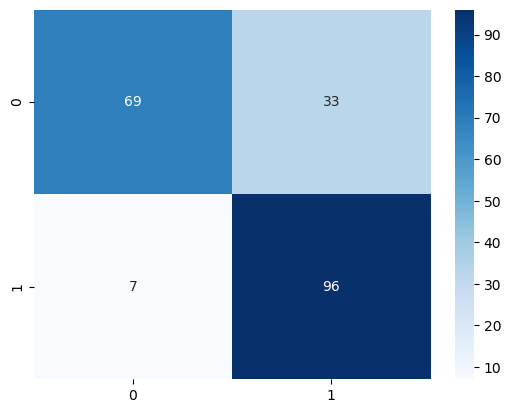

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, predictions.predicted_label)
plt.figure()
sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()

## Optimal Probability Cutoff

In [26]:
def Plot_roc_curve(actual, probs):
    fpr, tpr, thresholds = metrics.roc_curve(actual, probs, drop_intermediate=False)
    auc_score = metrics.roc_auc_score(actual, probs)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

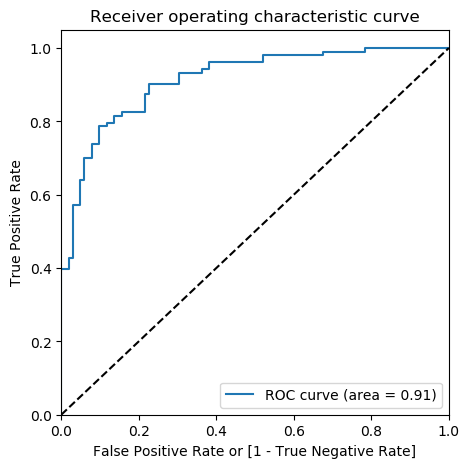

In [29]:
Plot_roc_curve(y_test, predictions.score)

In [30]:
for i in [n/10 for n in range(10)]:
    predictions[i] = predictions.score.map(lambda x: 1 if x > i else 0)
predictions.head()

,score,predicted_label,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.806170,1,1,1,1,1,1,1,1,1,1,0
1,0.963263,1,1,1,1,1,1,1,1,1,1,1
2,0.554910,1,1,1,1,1,1,1,0,0,0,0
3,0.077986,0,1,0,0,0,0,0,0,0,0,0
4,0.806170,1,1,1,1,1,1,1,1,1,1,0


In [31]:
cutoff_scores = pd.DataFrame(columns=['Probability','Accuracy','Sensitivity','Specificity'], dtype=float)

for i in [n/10 for n in range(10)]:
    cm = metrics.confusion_matrix(predictions.predicted_label, predictions[i])
    total=sum(sum(cm))
    accuracy = (cm[0,0]+cm[1,1])/total
    
    speci = cm[0,0]/(cm[0,0]+cm[0,1])
    sensi = cm[1,1]/(cm[1,0]+cm[1,1])
    cutoff_scores.loc[i] =[i, accuracy, sensi, speci]
    
cutoff_scores

,Probability,Accuracy,Sensitivity,Specificity
0.0,0.0,0.629268,1.000000,0.000000
0.1,0.1,0.878049,1.000000,0.671053
0.2,0.2,0.917073,1.000000,0.776316
0.3,0.3,0.946341,1.000000,0.855263
0.4,0.4,0.965854,1.000000,0.907895
0.5,0.5,1.000000,1.000000,1.000000
0.6,0.6,0.921951,0.875969,1.000000
0.7,0.7,0.858537,0.775194,1.000000
0.8,0.8,0.702439,0.527132,1.000000
0.9,0.9,0.565854,0.310078,1.000000


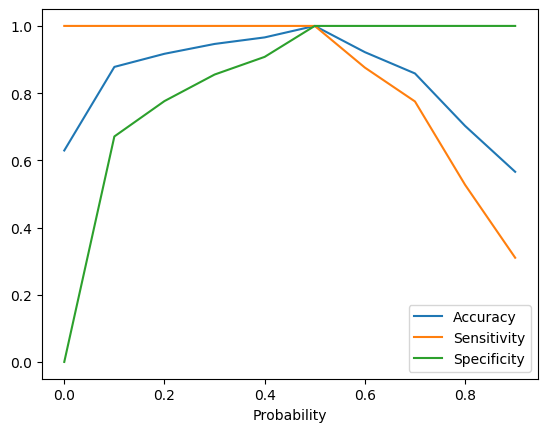

In [32]:
cutoff_scores.plot.line(x='Probability', y=['Accuracy','Sensitivity','Specificity'])
plt.show()

In [35]:
predictions["cutoff-4.5 prediction"] = predictions.score.map(lambda x: 1 if x > 0.45 else 0)
predictions.head()

,score,predicted_label,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,cutoff-4.2 prediction,cutoff-4.5 prediction
0,0.806170,1,1,1,1,1,1,1,1,1,1,0,1,1
1,0.963263,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0.554910,1,1,1,1,1,1,1,0,0,0,0,1,1
3,0.077986,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0.806170,1,1,1,1,1,1,1,1,1,1,0,1,1


In [36]:
print("Precision: ", metrics.precision_score(y_test, predictions["cutoff-4.5 prediction"]))
print("Recall: ", metrics.recall_score(y_test, predictions["cutoff-4.5 prediction"]))
print("Accuracy: ", metrics.accuracy_score(y_test, predictions["cutoff-4.5 prediction"]))

Precision:  0.7238805970149254
Recall:  0.941747572815534
Accuracy:  0.7902439024390244


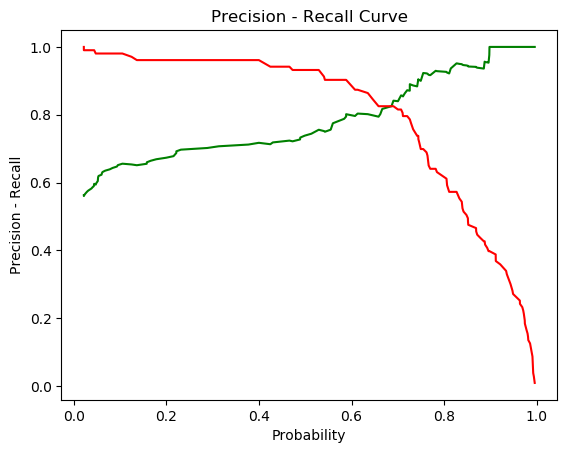

In [37]:
from sklearn.metrics import precision_recall_curve

p, r, thresholds = precision_recall_curve(y_test, predictions.score)
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.xlabel('Probability')
plt.ylabel('Precision - Recall')
plt.title('Precision - Recall Curve')
plt.show()

In [38]:
linear_classifier.delete_endpoint()